In [90]:
# Essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from datetime import datetime
import random
from tqdm import tqdm_notebook as tqdm
from PIL import Image
# Sklearn
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset
# TorchVision
from torchvision import models, transforms
from torchvision.utils import make_grid

# EDA

In [95]:
df_train = pd.read_csv('../input/3md3070-dlmi/trainset/trainset_true.csv')
df_train['GENDER'] = df_train.GENDER.apply(lambda x: int(x=='F'))
df_train['DOB'] = df_train['DOB'].apply(lambda x: x.replace("-", "/"))
df_train.head()

,ID,LABEL,GENDER,DOB,LYMPH_COUNT
0,P26,1,0,11/3/1933,11.2
1,P183,1,0,5/15/1942,12.8
2,P89,1,0,6/19/1935,9.6
3,P123,1,0,1/27/1931,122.6
4,P61,1,1,3/5/1931,11.6


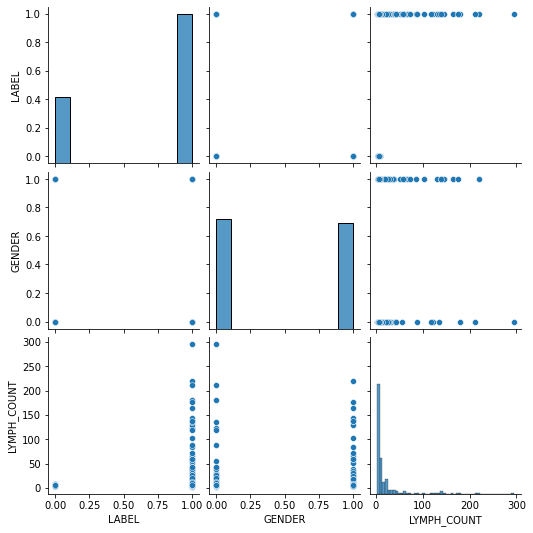

In [31]:
sns.pairplot(df_train[['LABEL', 'GENDER', 'LYMPH_COUNT']])

In [20]:
df_test = pd.read_csv('../input/3md3070-dlmi/testset/testset_data.csv')
df_test.head()

,ID,LABEL,GENDER,DOB,LYMPH_COUNT
0,P71,-1,M,1/17/1946,5.76
1,P16,-1,M,3/5/1940,32.00
2,P114,-1,M,6/16/1929,4.60
3,P170,-1,M,11/3/1933,4.80
4,P98,-1,F,5/14/1970,6.24


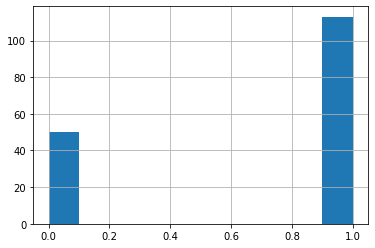

In [8]:
df_train.LABEL.hist()
plt.show()

In [6]:
def show_sample(group, shape=(5,2), figsize=(15,15)):
    total_samples = shape[0]*shape[1]
    nrow = shape[0]
    
    path_samples = random.sample(os.listdir(f'../input/3md3070-dlmi/trainset/{group}'),total_samples)
    batch_tensor = []
    for path in path_samples:
        img = transforms.ToTensor()(Image.open(os.path.join(f'../input/3md3070-dlmi/trainset/{group}', path)).convert("RGB")).unsqueeze(0)
        batch_tensor.append(img)
    batch_tensor = torch.cat(batch_tensor)
    grid_img = make_grid(batch_tensor, nrow=nrow)
    plt.figure(figsize=figsize)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

Showing 10 samples from P0


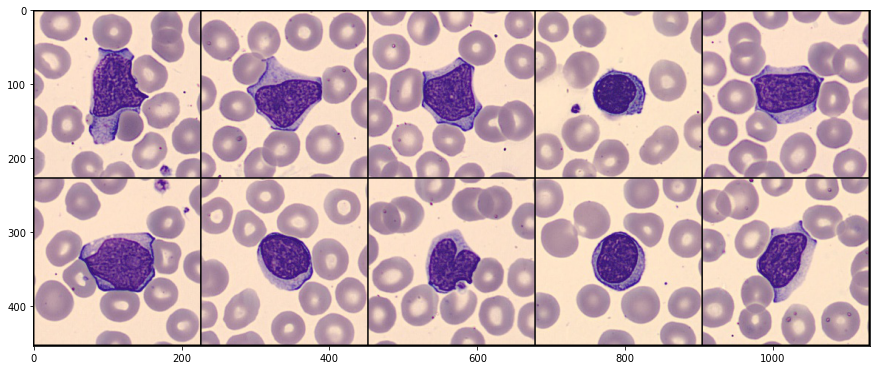

In [7]:
print("Showing 10 samples from P0")
show_sample("P0")

# Baselines
### Random Predictor
In this section we evaluate a random predictor on the training set

In [17]:
random.seed(42)
y_pred_random = []
for i in range(len(df_train)):
    y_pred_random.append(random.choice([0,1]))
print("Random predictor got", balanced_accuracy_score(df_train.LABEL, y_pred_random))

Random predictor got 0.4346902654867256


### Dummy Predictor

In this section we evaluate the performance of a dummy predictor that only outputs the most frequent label, 1 in this case on the training set.

In [19]:
y_pred_dummy = []
for i in range(len(df_train)):
    y_pred_dummy.append(1)
print("Dummy predictor got", balanced_accuracy_score(df_train.LABEL, y_pred_dummy))

Dummy predictor got 0.5


### LYMPH_COUNT Predictor
By looking at the dataset, we can see there's some correlation between the LYMPH_COUNT and the label. More specifically, the average value of the LYMPH_COUNT for 0 LABEL is 5 and for 1 is 35, so we'll empirically assign 0 to any bag with LYMPH_COUNT<=some_value and 1 otherwise

In [73]:
stratfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in stratfold.split(df_train, df_train.LABEL):
    X_train, X_val = df_train.LYMPH_COUNT[train_index].values.reshape(-1, 1), df_train.LYMPH_COUNT[test_index].values.reshape(-1, 1)
    y_train, y_val = df_train.LABEL[train_index], df_train.LABEL[test_index]
    y_pred = [int(x>7) for x in X_val]
    print("Balanced Accuracy Score", balanced_accuracy_score(y_val, y_pred))

Balanced Accuracy Score 0.8195652173913044
Balanced Accuracy Score 0.8195652173913044
Balanced Accuracy Score 0.8478260869565217
Balanced Accuracy Score 0.8409090909090908
Balanced Accuracy Score 0.9318181818181819


Let's make a first submission with this baseline, we can probably get more just by making a linear regression, but let's try this simple approach first!

In [64]:
sub_dict = {"ID":df_test.ID.values, "Predicted": [int(df_test.iloc[i,4]>7) for i in range(len(df_test))]}
df_sub = pd.DataFrame.from_dict(sub_dict)
df_sub.to_csv('submission.csv')

This approach yields a score of 0.82337 on the public LB.

### Logistic Regression
Since the last approach seemed to work, let's try to apply a logistic regression on the LYMPH COUNT variable.

In [74]:
stratfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in stratfold.split(df_train, df_train.LABEL):
    X_train, X_val = df_train.LYMPH_COUNT[train_index].values.reshape(-1, 1), df_train.LYMPH_COUNT[test_index].values.reshape(-1, 1)
    y_train, y_val = df_train.LABEL[train_index], df_train.LABEL[test_index]
    clf = LogisticRegression(random_state=42).fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print("Balanced Accuracy Score", balanced_accuracy_score(y_val, y_pred))

Balanced Accuracy Score 0.8130434782608695
Balanced Accuracy Score 0.7347826086956522
Balanced Accuracy Score 0.8695652173913043
Balanced Accuracy Score 0.759090909090909
Balanced Accuracy Score 0.7818181818181817


# DataLoading

In [ ]:
class LymphBags(torch.utils.data.Dataset):
    def __init__(self, bags_dir, df, mode='train', transforms=None):
        self.transforms = transforms
        self.mode = mode
        self.df = df
        self.bags_dir = bags_dir

    def __len__(self):
        return len(os.listdir(self.bags_dir))
        
    def __getitem__(self, index):
        if self.train:
            bag = self.train_bags_list[index]
            label = [max(self.train_labels_list[index]), self.train_labels_list[index]]
            return bag, label
        else:
            bag = self.test_bags_list[index]
            return bag

        


# CNN Baseline

We will be using a model from the paper ["Attention-based Deep Multiple Instance Learning"](https://arxiv.org/pdf/1802.04712v4.pdf)

In [22]:
class Attention(nn.Module):
    def __init__(self, L=500, D=128, K=1):
        super(Attention, self).__init__()
        self.L = L
        self.D = D
        self.K = K

        self.feature_extractor_part1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(50 * 4 * 4, self.L),
            nn.ReLU(),
        )

        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.L*self.K, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.squeeze(0)

        H = self.feature_extractor_part1(x)
        H = H.view(-1, 50 * 4 * 4)
        H = self.feature_extractor_part2(H)  # NxL

        A = self.attention(H)  # NxK
        A = torch.transpose(A, 1, 0)  # KxN
        A = F.softmax(A, dim=1)  # softmax over N

        M = torch.mm(A, H)  # KxL

        Y_prob = self.classifier(M)
        Y_hat = torch.ge(Y_prob, 0.5).float()

        return Y_prob, Y_hat, A

    # AUXILIARY METHODS
    def calculate_classification_error(self, X, Y):
        Y = Y.float()
        _, Y_hat, _ = self.forward(X)
        error = 1. - Y_hat.eq(Y).cpu().float().mean().data[0]

        return error, Y_hat

    def calculate_objective(self, X, Y):
        Y = Y.float()
        Y_prob, _, A = self.forward(X)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=1. - 1e-5)
        neg_log_likelihood = -1. * (Y * torch.log(Y_prob) + (1. - Y) * torch.log(1. - Y_prob))  # negative log bernoulli

        return neg_log_likelihood, A

Here we define the training function:

In [23]:
def train(epoch):
    model.train()
    train_loss = 0.
    train_error = 0.
    for batch_idx, (data, label) in enumerate(train_loader):
        bag_label = label[0]
        if args.cuda:
            data, bag_label = data.cuda(), bag_label.cuda()
        data, bag_label = Variable(data), Variable(bag_label)

        # reset gradients
        optimizer.zero_grad()
        # calculate loss and metrics
        loss, _ = model.calculate_objective(data, bag_label)
        train_loss += loss.data[0]
        error, _ = model.calculate_classification_error(data, bag_label)
        train_error += error
        # backward pass
        loss.backward()
        # step
        optimizer.step()

    # calculate loss and error for epoch
    train_loss /= len(train_loader)
    train_error /= len(train_loader)

    print('Epoch: {}, Loss: {:.4f}, Train error: {:.4f}'.format(epoch, train_loss.cpu().numpy()[0], train_error))